# Preliminary Data Exploration
### Steps Dataset

##### 1. Verify the Structure

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [31]:
steps = pd.read_csv("../data/raw/steps/steps.csv")

steps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         18 non-null     object
 1   steps_taken  18 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 420.0+ bytes


In [32]:
steps.head()

,date,steps_taken
0,2024-12-21,4664
1,2024-12-22,16819
2,2024-12-23,13460
3,2024-12-24,10506
4,2024-12-25,2804


##### 2. Identify Missing Values

In [33]:
steps.isnull().sum()

date           0
steps_taken    0
dtype: int64

##### 3. Handle Missing Values

This dataset doesn't have missing values.

##### 4. Correcting Formats and Data Types

We ensure `date` column to be `datetime` format and `steps_taken` to be `integer`

In [34]:
steps['date'] = pd.to_datetime(steps['date'])

steps.dtypes

date           datetime64[ns]
steps_taken             int64
dtype: object

##### 5. Identify Outliers

##### IQR: Interquartile Range
IQR (Interquartile Range) is defined as the difference between the 75th percentile and 25th percentiles of the data.

References: https://en.wikipedia.org/wiki/Interquartile_range

Compute Q1 and Q3, using ``.quantile()`` function provided by Pandas. Particularly, we use the ``linear`` method for interpolation in identifying Q1 and Q3. How does linear interpolation work?
 
**Step 1: Calculate Position (P)** <br>
The position **P** of the quantile in the ordered data is computed as:
$$
P = (n - 1) \cdot q + 1
$$
Where:
- **n**: Total number of data points
- **q**: Desired quantile (e.g., \( q = 0.25 \) for Q1, \( q = 0.75 \) for Q3)

The result **P** determines the position of the quantile in the sorted data:
- If **P** is an **integer**, the quantile corresponds directly to the value at position \( P \).
- If **P** is **not an integer**, linear interpolation is used between the two closest values.

-----

**Step 2: Linear Interpolation for Non-Integer Positions**

If **P** is not an integer, the quantile is computed as:
$$
\text{quantile} = v_i + (v_{i+1} - v_i) \cdot (P - i)
$$

-----

References: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html

In [35]:
ordered_steps = steps['steps_taken'].sort_values(ascending=True)
ordered_steps

17      168
4      2804
15     4218
0      4664
12     5350
16     7175
14     7958
13     8135
6      8250
3     10506
11    10803
5     11066
2     13460
7     13875
1     16819
9     17121
10    17157
8     20076
Name: steps_taken, dtype: int64

In [36]:
Q1 = ordered_steps.quantile(0.25, interpolation='linear')
Q3 = ordered_steps.quantile(0.75, interpolation='linear')
print(Q1, Q3)

5806.25 13771.25


In [37]:
IQR = Q3 - Q1
print(IQR)

7965.0


**IQR to identify outliers in data**

IQR is often used to find outliers in data. Outliers here are defined as observations that fall below Q1 − 1.5 IQR or above Q3 + 1.5 IQR. 

References: https://en.wikipedia.org/wiki/Interquartile_range

In [38]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

Lower Bound: -6141.25, Upper Bound: 25718.75


Lower Bound is a negative number: let's remove the last row from ``steps`` dataset. The last row represents the number of steps taken today.

In [39]:
filtered_steps = steps.drop(steps.tail(1).index)
ordered_filtered_steps = filtered_steps['steps_taken'].sort_values(ascending=True)

In [40]:
ordered_filtered_steps

4      2804
15     4218
0      4664
12     5350
16     7175
14     7958
13     8135
6      8250
3     10506
11    10803
5     11066
2     13460
7     13875
1     16819
9     17121
10    17157
8     20076
Name: steps_taken, dtype: int64

In [41]:
Q1 = ordered_filtered_steps.quantile(0.25, interpolation='linear')
Q3 = ordered_filtered_steps.quantile(0.75, interpolation='linear')
print(Q1, Q3)

7175.0 13875.0


In [42]:
IQR = Q3 - Q1
print(IQR)

6700.0


In [43]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

Lower Bound: -2875.0, Upper Bound: 23925.0


Lower Bound is a negative number again.

In [44]:
lower_bound = max(100, Q1 - 1.5 * IQR)
print(f"Lower Bound updated: {lower_bound}")

Lower Bound updated: 100


In [45]:
outliers = filtered_steps[(filtered_steps['steps_taken'] < lower_bound) | (filtered_steps['steps_taken'] > upper_bound)]
print("Outliers detected:")
print(len(outliers))

Outliers detected:
0


##### 6. Visualize a boxplot

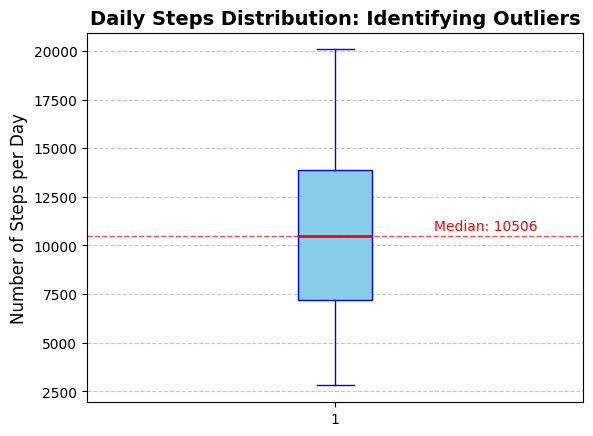

In [46]:
median_value = filtered_steps['steps_taken'].median()

plt.boxplot(
    filtered_steps['steps_taken'],
    patch_artist=True,
    boxprops=dict(facecolor='skyblue', color='blue'),
    medianprops=dict(color='red',linewidth=2),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    flierprops=dict(markerfacecolor='orange', markeredgecolor='red', markersize=8)
)

plt.axhline(median_value, color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.text(
    x=1.2,
    y=median_value+500,
    s=f"Median: {int(median_value)}",
    color='red', 
    fontsize=10,
    verticalalignment='center',
    horizontalalignment='left'
)

plt.title("Daily Steps Distribution: Identifying Outliers", fontsize=14, fontweight='bold')
plt.ylabel("Number of Steps per Day", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##### 7. Check for Duplicate Data

In [47]:
date_counts = filtered_steps['date'].value_counts()
duplicate_data = date_counts[date_counts > 1]
print("Duplicate Data Detected:")
print(len(duplicate_data))

Duplicate Data Detected:
0


##### 8. Identify Missing Dates

In [48]:
start_date = "2024-12-21"
end_date = "2025-01-06"

full_date_range = pd.date_range(start=start_date, end=end_date, freq="D")
print(full_date_range)

DatetimeIndex(['2024-12-21', '2024-12-22', '2024-12-23', '2024-12-24',
               '2024-12-25', '2024-12-26', '2024-12-27', '2024-12-28',
               '2024-12-29', '2024-12-30', '2024-12-31', '2025-01-01',
               '2025-01-02', '2025-01-03', '2025-01-04', '2025-01-05',
               '2025-01-06'],
              dtype='datetime64[ns]', freq='D')


In [49]:
dataset_dates = set(filtered_steps['date'])

missing_dates = set(full_date_range) - dataset_dates
print(f"Missing dates: {missing_dates}")
print(f"How many missing dates? {len(missing_dates)}")

Missing dates: set()
How many missing dates? 0


##### Cleaning Process Completed: save data as cleaned

In [ ]:
output_dir = "../data/cleaned/steps"
output_file = os.path.join(outputi)